<a href="https://www.kaggle.com/code/sagnikdebnath007/vae-from-scratch?scriptVersionId=211167090" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

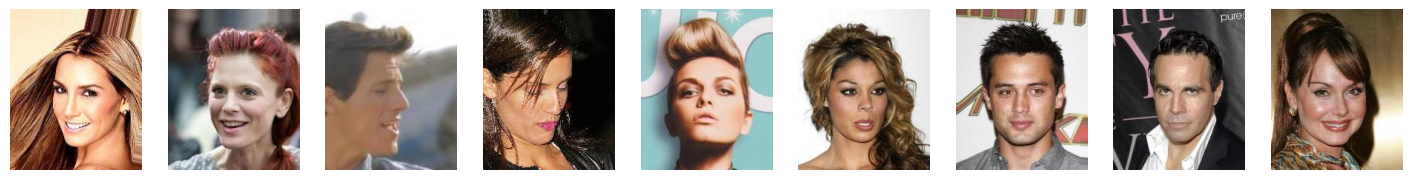

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

for i in range(1,10):   
    plt.subplot(1,10,i+1)    
    filename = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/00000' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [41]:
import os
import torch 
import torch.nn as nn #nn layers
import torch.optim as optim #optimization algos
import torch.nn.functional as F #activation funcs like relu,tanh. Also included in nn
from torch.utils.data import Dataset,DataLoader,random_split #Makes data using easy
import torchvision.datasets as datasets #for datasets
import torchvision.transforms as transforms #used for data augmentation
from PIL import Image

In [42]:
class DatasetLoader(Dataset):
    def __init__(self,root,transform=False):
        self.root=root
        self.transform=transform
        self.img_paths=sorted(os.listdir(os.path.join(root, "img_align_celeba")))
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "img_align_celeba", self.img_paths[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [43]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [44]:
dataset=DatasetLoader(root='/kaggle/input/celeba-dataset/img_align_celeba',transform=transform)

In [45]:
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [46]:
class VariationalAutoencoder(nn.Module):
    def __init__(self,input_dim=3,latent_dim=128):
        super(VariationalAutoencoder,self).__init__()
        self.input_dim=input_dim
        self.latent_dim=latent_dim
        self.encoder=nn.Sequential(
            nn.Conv2d(input_dim,16,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.Conv2d(16,32,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.Conv2d(32,64,kernel_size=6,stride=4,padding=1),
            nn.SiLU()    
        )
        self.mu=nn.Linear(64*4*4,latent_dim)
        self.logvar=nn.Linear(64*4*4,latent_dim)
        self.inver_flatten=nn.Linear(latent_dim,64*4*4)
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(32,16,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(16,input_dim,kernel_size=6,stride=4,padding=1),
            nn.Tanh()
        )

    def reparameterize(self,mu,logvar):
        eps=torch.randn_like(logvar)
        sigma=torch.exp(0.5*logvar)
        z=mu+eps*sigma
        return z

    def forward(self,x):
        batch_size=x.shape[0]
        encoded=self.encoder(x).view(batch_size,-1)
        mu=self.mu(encoded)
        logvar=self.logvar(encoded)
        z=self.reparameterize(mu,logvar)
        inverse_flattened=self.inver_flatten(z).view(batch_size,64,4,4)
        decoded=self.decoder(inverse_flattened)
        return decoded,mu,logvar

In [47]:
def vae_loss(x,x_hat,mask,mu,logvar):
    autoencoder_loss=nn.MSELoss(reduction='sum')(x_hat*mask,x*mask)
    kl_loss=-0.5*torch.sum(1+logvar-mu.pow(2)-torch.exp(logvar))
    return autoencoder_loss+kl_loss

In [48]:
from tqdm import tqdm

In [49]:
model = VariationalAutoencoder(input_dim=3, latent_dim=128).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [50]:
model

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(32, 64, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (5): SiLU()
  )
  (mu): Linear(in_features=1024, out_features=128, bias=True)
  (logvar): Linear(in_features=1024, out_features=128, bias=True)
  (inver_flatten): Linear(in_features=128, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): SiLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (3): SiLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (5): Tanh()
  )
)

In [51]:
def apply_random_mask(images, mask_size=16):
    B, C, H, W = images.size()
    masked_images = images.clone()
    mask = torch.ones_like(images) 

    for i in range(B):
        top = torch.randint(0, H - mask_size, (1,))
        left = torch.randint(0, W - mask_size, (1,))
        masked_images[i, :, top:top+mask_size, left:left+mask_size] = 0
        mask[i, :, top:top+mask_size, left:left+mask_size] = 0

    return masked_images, mask

In [ ]:
epochs=10
for epoch in range(epochs):
    model.train()
    train_loss=0.0
    for img in tqdm(train_loader,desc=f'Epoch:{epoch+1}'):
        img=img.to('cuda')
        
        masked_images, mask = apply_random_mask(img, mask_size=16)
        x_hat,mu,logvar=model(masked_images)
        
        x_hat=x_hat.to('cuda')
        mu=mu.to('cuda')
        logvar=logvar.to('cuda')
        
        loss=vae_loss(img,x_hat,mask,mu,logvar).to('cuda')
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    print(f"Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch:1: 100%|██████████| 20260/20260 [15:44<00:00, 21.45it/s]


Loss: 8614.6192


Epoch:2: 100%|██████████| 20260/20260 [11:54<00:00, 28.37it/s]


Loss: 6454.5532


Epoch:3: 100%|██████████| 20260/20260 [11:45<00:00, 28.70it/s]


Loss: 6243.7044


Epoch:4: 100%|██████████| 20260/20260 [11:21<00:00, 29.73it/s]


Loss: 6139.9580


Epoch:5: 100%|██████████| 20260/20260 [12:23<00:00, 27.25it/s]


Loss: 6072.5010


Epoch:6: 100%|██████████| 20260/20260 [12:17<00:00, 27.46it/s]


Loss: 6026.3394


Epoch:7: 100%|██████████| 20260/20260 [11:38<00:00, 29.00it/s]


Loss: 5991.3088


Epoch:8: 100%|██████████| 20260/20260 [11:16<00:00, 29.95it/s]


Loss: 5963.4457


Epoch:9:   8%|▊         | 1564/20260 [00:48<09:40, 32.18it/s]